In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import math
import torch.optim as optim


In [2]:
#设置一些参数
seq_len = 96
predict_len = 384
batch_size = 512
num_epochs = 100
lr = 0.01
p=0.75
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def random_loss(data,p):
    #表示以一定的概率进行数据丢失
    mask = torch.rand_like(data) < p
    data_observed = data.clone()  # 观测到的数据
    data_observed[mask] = 0  # 设置缺失值
    return data_observed

In [4]:
def get_data(seq_len,predict_len):
    df_airq = pd.read_csv('./data/airquality.csv')
    
    station_list = np.unique(df_airq['station_id'])[:36]
    print(station_list)
    
    data = []
    for station in station_list:
        data_one = pd.read_csv('./data/stations_data/df_station_{}.csv'.format(station))['PM25_Concentration']
        data_one = data_one.ffill()
        data_one = data_one.bfill()

        data_one = np.array(data_one)
        
        
        data.append(data_one)
    data = np.array(data)
    max_value = np.max(data_one)
    min_value = np.min(data_one)

    # 应用正规化公式
    data = (data- min_value) / (max_value - min_value)
    print(data)
    print(data.shape)#the shape of data is (36,8760)
    
    x = []
    y = []
    for i in range(data.shape[0]):
        x_one = []
        for j in range(data.shape[1]-seq_len-predict_len):
            x_one.append(data[i][j:j+seq_len])
        x_one = np.array(x_one)
        x.append(x_one)
    x = np.array(x)
    
    data_y = pd.read_csv('./data/stations_data/df_station_1001.csv')['PM25_Concentration']
    data_y = data_y.ffill()
    data_y = data_y.bfill()
    data_y = np.array(data_y)
    for i in range(seq_len,data_y.shape[0]-predict_len):
        y.append(data_y[i:i+predict_len])
    y = np.array(y)
    x = x.transpose(1,0,2)
    
    train = int(y.shape[0] * 0.75)
    valid = int(y.shape[0] * 0.125)
    x_train,x_valid,x_test = x[:train],x[train:train+valid],x[train+valid:]
    y_train,y_valid,y_test = y[:train],y[train:train+valid],y[train+valid:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test

In [5]:
x_train,x_valid,x_test,y_train,y_valid,y_test = get_data(seq_len,predict_len)

[1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014
 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1035 1036]
[[0.17532468 0.15714286 0.16103896 ... 0.1        0.0987013  0.0987013 ]
 [0.11168831 0.10649351 0.11038961 ... 0.09220779 0.09090909 0.09090909]
 [0.13246753 0.15324675 0.16493506 ... 0.10909091 0.11688312 0.11688312]
 ...
 [0.11818182 0.12727273 0.14155844 ... 0.21168831 0.31298701 0.31298701]
 [0.14155844 0.15584416 0.18181818 ... 0.0974026  0.11818182 0.11818182]
 [0.13766234 0.14415584 0.15974026 ... 0.11818182 0.11038961 0.11038961]]
(36, 8760)


In [6]:
class Mydataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        x = self.x[idx]
        if self.transform:
            x = self.transform(x)
        return x,self.y[idx]

In [7]:
train_dataset = Mydataset(x_train,y_train)
valid_dataset = Mydataset(x_valid,y_valid)
test_dataset = Mydataset(x_test,y_test)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        return x

In [9]:

class SelfAttention(nn.Module):
    def __init__(self,embed_size,heads):
        super(SelfAttention,self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size),"Embed size needs to be divided by heads"

        self.values = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.keys = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.queries = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.fc_out = nn.Linear(heads * self.head_dim,embed_size)

    def forward(self,values,keys,query,mask=None):
        N = query.shape[0]
        value_len,key_len,query_len = values.shape[1],keys.shape[1],query.shape[1]

        #split embedding into self.heads pieces
        values = values.reshape(N,value_len,self.heads,self.head_dim)
        keys = keys.reshape(N,key_len,self.heads,self.head_dim)
        queries = query.reshape(N,key_len,self.heads,self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk",[queries,keys])
        #queries shape:(N,query_len,heads,head_dim)
        #keys shape:(N,key_len,heads,heads_dim)
        #energy shape:(N,heads,query_len,key_len)

        if mask is not None:
            energy = energy.masked_fill(mask == 0,float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)),dim = 3)
        #print(attention.shape)
        out = torch.einsum("nhql,nlhd->nqhd",[attention,values]).reshape(
            N,query_len,self.heads*self.head_dim
        )

        out = self.fc_out(out)
        #print(attention.shape)
        return attention[:,0,:,:],out

class TransformerBlock(nn.Module):
    def __init__(self,embed_size,heads,dropout,forward_expansion,device):
        super(TransformerBlock,self).__init__()
        self.attention = SelfAttention(embed_size,heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size,forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size,embed_size)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(2,1),stride=(2,1)),
            nn.BatchNorm2d(16),
            #nn.AvgPool2d(kernel_size=(2,1),stride=(2,1)),
            nn.Conv2d(16,1,kernel_size=3,padding=1)
        )
        self.dropout = nn.Dropout(dropout)
        self.device = device
    #对attention进行处理，获取关系最近的两个点进行聚合
    def Aggre(self,x,attention):
        #其中x表示输入数值，attention表示每个点之间的关系
        #shape of x (N,seq_len,embed_size),shape of attention(N,seq_len,seq_len)
        #print(x.shape)
        N,seq_len = x.shape[0],x.shape[2]
        attention = attention.cpu().detach().numpy()
        #print(attention.shape)
        x = x.cpu().detach().numpy()
        data = []
        for i in range(N):
            data_one = []
            vis = []
            for j in range(x.shape[1]):
                #寻找每一行最大值的下标
                max_value = np.argmax(attention[i,:,:],axis=1)
                #print(max_value)
                if j not in vis:
                    vis.append(j)
                    data_one.append(x[i,j,:])
                    if max_value[j] not in vis:
                        vis.append(max_value[j])
                        data_one.append(x[i,max_value[j],:])
            data.append(data_one)
        data = torch.tensor(np.array(data)).to(self.device)
        #print(data.shape)
        return data
                    
                
                
    def forward(self,value,key,query,mask=None):
        attention,out = self.attention(value,key,query,mask)
        #这里的attention表示每个点与其他点之间的关系
        x = self.dropout(self.norm1(out + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        #这里对注意力进行重新排序，并使用二维卷积聚合
        attention = self.Aggre(out,attention)
        attention = self.conv(attention.unsqueeze(dim=1)).squeeze(dim=1)
        return attention,out

In [10]:
class SpatialBlock(nn.Module):
    def __init__(self,in_channels, out_channels,embed_size,heads,dropout,forward_expansion,device):
        super(SpatialBlock,self).__init__()
        self.gcn = GCN(in_channels,out_channels)
        self.transformer = TransformerBlock(out_channels,heads,dropout,forward_expansion,device)
    def forward(self,data,x,mask=None):
        #the shape of x:(N,num_station,embed_size)
        x = self.gcn(data)
        attention,out = self.transformer(x,x,x,mask)
        return attention,out

In [11]:
class T_SelfAttention(nn.Module):
    def __init__(self,embed_size,heads):
        super(T_SelfAttention,self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size),"Embed size needs to be divided by heads"

        self.values = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.keys = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.queries = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.fc_out = nn.Linear(heads * self.head_dim,embed_size)

    def forward(self,values,keys,query,mask=None):
        N = query.shape[0]
        value_len,key_len,query_len = values.shape[1],keys.shape[1],query.shape[1]

        #split embedding into self.heads pieces
        values = values.reshape(N,value_len,self.heads,self.head_dim)
        keys = keys.reshape(N,key_len,self.heads,self.head_dim)
        queries = query.reshape(N,key_len,self.heads,self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk",[queries,keys])
        #queries shape:(N,query_len,heads,head_dim)
        #keys shape:(N,key_len,heads,heads_dim)
        #energy shape:(N,heads,query_len,key_len)

        if mask is not None:
            energy = energy.masked_fill(mask == 0,float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)),dim = 3)

        out = torch.einsum("nhql,nlhd->nqhd",[attention,values]).reshape(
            N,query_len,self.heads*self.head_dim
        )

        out = self.fc_out(out)
        return out

class TemporalBlock(nn.Module):
    def __init__(self,embed_size,heads,dropout,forward_expansion):
        super(TemporalBlock,self).__init__()
        self.attention = T_SelfAttention(embed_size,heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size,forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size,embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query,mask=None):
        attention = self.attention(value,key,query,mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [12]:
class PositionalEmbedding(nn.Module):
    def __init__(self,d_model,max_len = 5000):
        super(PositionalEmbedding,self).__init__()
        #Compute the positional encodings once in log space
        pe = torch.zeros(max_len,d_model).float()
        pe.requires_grad = False

        position = torch.arange(0,max_len).float().unsqueeze(1)
        div_term = (torch.arange(0,d_model,2).float() * -(math.log(10000.0)/d_model)).exp()

        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe',pe)

    def forward(self,x):
        return self.pe[:,:x.size(1)]

In [13]:
class Multi_Spatial(nn.Module):
    def __init__(self,in_channels, out_channels,embed_size,seq_len,predict_len,heads,dropout,forward_expansion,num_blocks,device):
        self.num_blocks = num_blocks
        self.embed_size = embed_size
        self.device = device
        super(Multi_Spatial,self).__init__()
        self.blocks = nn.ModuleList([
            SpatialBlock(in_channels, out_channels,embed_size,heads,dropout,forward_expansion,device) for i in range(num_blocks)
        ])
        self.position_embedding = PositionalEmbedding(d_model=embed_size)
        self.fc = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(36,128),
                    nn.ReLU(),
                    
                    nn.Linear(128,256),
                    nn.ReLU(),
                    
                    nn.Linear(256,512)
                ),
                nn.Sequential(
                    nn.Linear(18,128),
                    nn.ReLU(),
                    
                    nn.Linear(128,256),
                    nn.ReLU(),
                    
                    nn.Linear(256,512)
                ),
                nn.Sequential(
                    nn.Linear(9,128),
                    nn.ReLU(),
                    
                    nn.Linear(128,256),
                    nn.ReLU(),
                    
                    nn.Linear(256,512)
                ),
                nn.Sequential(
                    nn.Linear(4,128),
                    nn.ReLU(),
                    
                    nn.Linear(128,256),
                    nn.ReLU(),
                    
                    nn.Linear(256,512)
                )
            ]
        )
        self.fc1 = nn.Linear(36,embed_size)
        self.norm = nn.LayerNorm(embed_size)
        self.temporal = nn.ModuleList([
            TemporalBlock(embed_size,heads,dropout,forward_expansion)for i in range(num_blocks-1)
        ])
        self.aggre = nn.Linear(4,1)
        self.fc_out1 = nn.Sequential(
            nn.Linear(embed_size,128),
            nn.ReLU(),
            
            nn.Linear(128,64),
            nn.ReLU(),
            
            nn.Linear(64,32),
            nn.ReLU(),
            
            nn.Linear(32,16),
            nn.ReLU(),
            
            nn.Linear(16,1),
            
        )
        self.fc_out = nn.Sequential(
            nn.Linear(seq_len,predict_len)
        )
        self.dropout = nn.Dropout(dropout)
        
    def create_mask(self,N):
        #生成一个矩阵，对角线上的值为0
        mask = torch.ones((N,N))
        for i in range(N):
            mask[i,i] = 0
        mask = mask.to(device)
        return mask
    
    def forward(self,x,mask=None):
        #the shape of x:(N,seq_len,36,embed_size)
        attentions = []
        res = self.fc1(x.transpose(1,2))
        for i in range(self.num_blocks-1):
            # 生成所有可能的边
            edges = [(i, i+1) for i in range(x.shape[1]-1)]
            # 将边转换为 edge_index 格式
            edge_index = torch.tensor([[from_node, to_node] for from_node, to_node in edges], dtype=torch.long).reshape(2,-1)
            edge_attr = torch.ones((edge_index.size(1),1))
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr).to(self.device)
            mask = self.create_mask(x.shape[1])
            x,attention = self.blocks[i](data,x,mask)
            #其中x是经过聚合之后的attention
            attentions.append(attention.transpose(1,2))
            
        xs = []   
        for i in range(len(attentions)):
            x = self.fc[i](attentions[i].reshape(attentions[i].shape[0],attentions[i].shape[1],-1))
            #the shape of x is(N,seq_len,embed_size)
            
            x = x + self.position_embedding(x)
            mask = self.create_mask(x.shape[1])
            x = self.temporal[i](x,x,x,mask)
            xs.append(x.unsqueeze(dim=3))
        #print(x.shape)
        new_x = xs[0]
        new_x = new_x.to(device)
        for i in range(len(xs)-1):
            new_x = torch.cat((new_x,xs[i+1]),dim=3)
        
        
        new_x = self.aggre(new_x).reshape(new_x.shape[0],new_x.shape[1],-1)
        new_x = new_x + res
        new_x = self.fc_out1(new_x).reshape(new_x.shape[0],-1)
        out = self.fc_out(new_x)
        return out      
        #这里要做一个全连接层聚合，需要测试输出维度

In [14]:
x = torch.randn(16,36,24*7)
model = Multi_Spatial(in_channels=seq_len, out_channels=seq_len,embed_size=512,seq_len=seq_len,
                      predict_len=predict_len,heads=8,dropout=0.5,forward_expansion=4,
                      num_blocks=5,device=device).to(device)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)

In [16]:
losses = []
val_losses = []
patience = 20  # 允许没有性能提升的epoch数量

# 初始化最佳损失和epoch计数器
best_loss = float('inf')
epoch_no_improve = 0
for epoch in range(num_epochs):
    model.train()
    for i,(x,y) in enumerate(train_loader):
        x = random_loss(x,p).float().to(device)
        #print(x.shape)
        y = y.float().to(device)
        model.zero_grad()
        output = model(x).to(device)
        loss = criterion(output,y)
        loss.backward()
        
        optimizer.step()
        
        if i % 10 == 0:
            print('epoch:{}/{},batch:{}/{},loss:{:.4f}'.format(epoch+1,num_epochs,i,len(train_loader),loss.item()))
            losses.append(loss.item())
    model.eval()
        
    validation_losses = []
    with torch.no_grad():
        for i,(x,y) in enumerate(valid_loader):
            x = random_loss(x,p).float().to(device)
            y = y.float().to(device)
            output = model(x)
            loss = criterion(output,y)
            validation_losses.append(loss.item())
        
        # 验证过程...
        validation_losses = np.array(validation_losses)
        validation_loss = np.mean(validation_losses)  # 计算验证集损失
        val_losses.append(validation_loss)
        
    
        # 检查是否是最佳模型
        if validation_loss < best_loss:
            best_loss = validation_loss
            print('best_loss:{:.4f}'.format(best_loss))
            epoch_no_improve = 0
            # 保存最佳模型的状态
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epoch_no_improve += 1
            print('validation_loss:{:.4f}'.format(validation_loss))
            print('epoch_no_improve:{}'.format(epoch_no_improve))
            if epoch_no_improve >= patience:
                print(f"Early stopping initiated after {epoch_no_improve} epochs without improvement.")
                break

epoch:1/100,batch:0/13,loss:12425.3203
epoch:1/100,batch:10/13,loss:8721.4014
best_loss:13338.1139
epoch:2/100,batch:0/13,loss:8230.8818
epoch:2/100,batch:10/13,loss:6817.3901
best_loss:8645.4150
epoch:3/100,batch:0/13,loss:5730.0093
epoch:3/100,batch:10/13,loss:6322.8979
best_loss:8462.3701
epoch:4/100,batch:0/13,loss:6232.6519
epoch:4/100,batch:10/13,loss:5990.6074
best_loss:8209.0710
epoch:5/100,batch:0/13,loss:5924.2275
epoch:5/100,batch:10/13,loss:6135.8516
validation_loss:8605.7620
epoch_no_improve:1
epoch:6/100,batch:0/13,loss:5471.5444
epoch:6/100,batch:10/13,loss:6070.8262
validation_loss:8834.9714
epoch_no_improve:2
epoch:7/100,batch:0/13,loss:5593.9956
epoch:7/100,batch:10/13,loss:5907.3311
validation_loss:8512.0828
epoch_no_improve:3
epoch:8/100,batch:0/13,loss:5868.1865
epoch:8/100,batch:10/13,loss:5971.0830
validation_loss:8845.1143
epoch_no_improve:4
epoch:9/100,batch:0/13,loss:5781.6992
epoch:9/100,batch:10/13,loss:6266.9194
validation_loss:8654.5710
epoch_no_improve:5


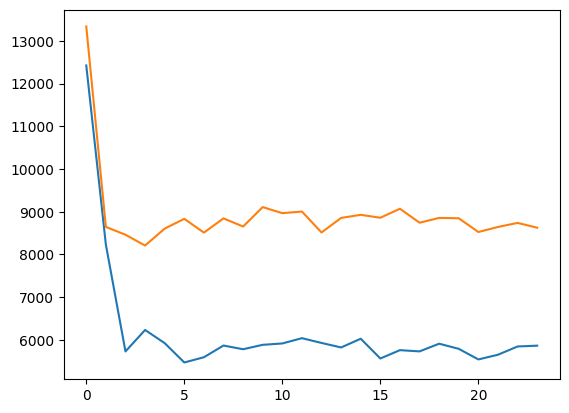

In [17]:
from matplotlib import pyplot as plt
losses = np.array(losses[::2])
val_losses = np.array(val_losses)
fig, ax = plt.subplots()
ax.plot(losses)
ax.plot(val_losses)
plt.show()


In [18]:
#接下来为测试过程，
test_model = Multi_Spatial(in_channels=seq_len, out_channels=seq_len,embed_size=512,
                           seq_len=seq_len,predict_len=predict_len,heads=8,dropout=0.5,
                           forward_expansion=4,num_blocks=5,device=device).to(device)
test_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [19]:
def test(model,device,tain_loader):
    histories = []
    predicts = []
    ground_truth=[]
    model.eval()
    mse = nn.MSELoss()
    
    with torch.no_grad():
        for i,(x,y) in enumerate(test_loader):
            x = random_loss(x,p).float().to(device)
            y = y.float().to(device)
            output = model(x)
            loss = mse(output,y)
            
            print('Test Loss:{:.4f}'.format(loss.item()))
            
            histories.append(x)
            predicts.append(output)
            ground_truth.append(y)
            
        return histories,predicts,ground_truth

In [20]:
histories,predicts,ground_truth = test(test_model,device,test_loader)

Test Loss:3932.3621
Test Loss:4005.3779
Test Loss:4084.7974


In [21]:
histories[0].shape

torch.Size([512, 36, 96])

[ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 34

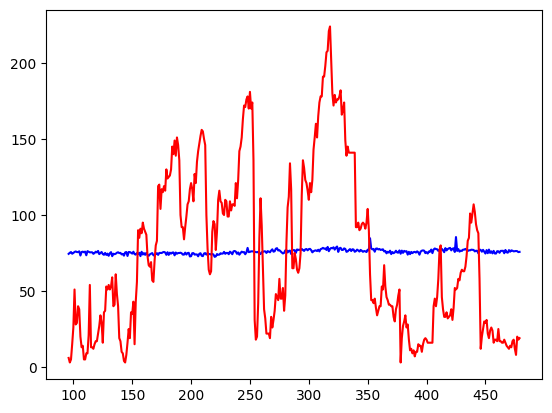

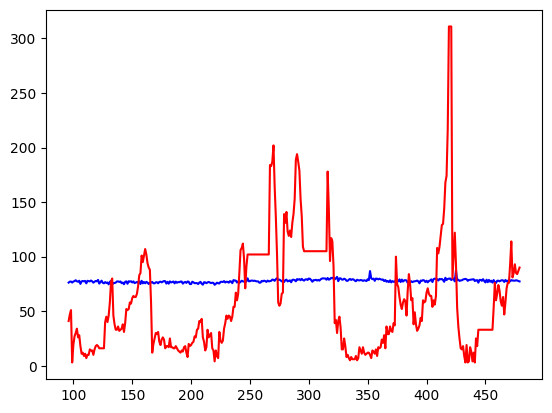

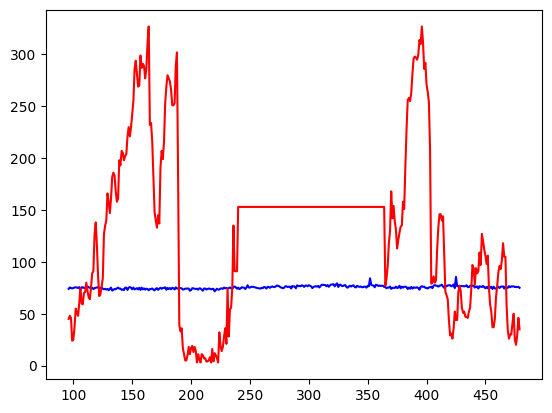

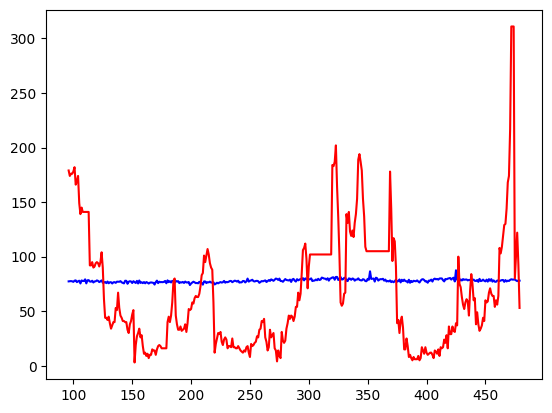

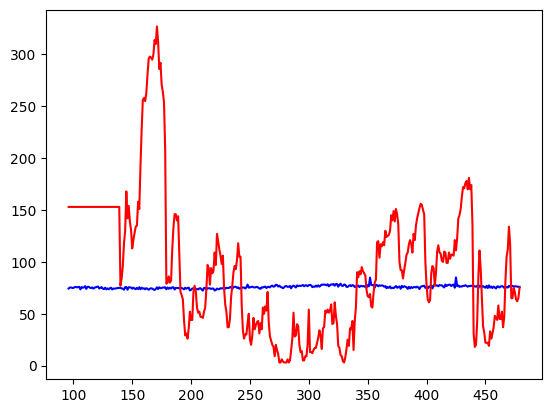

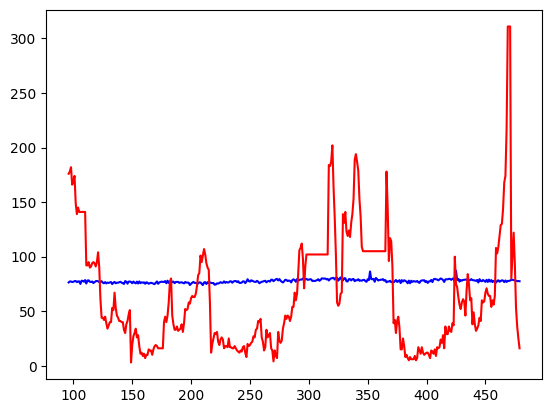

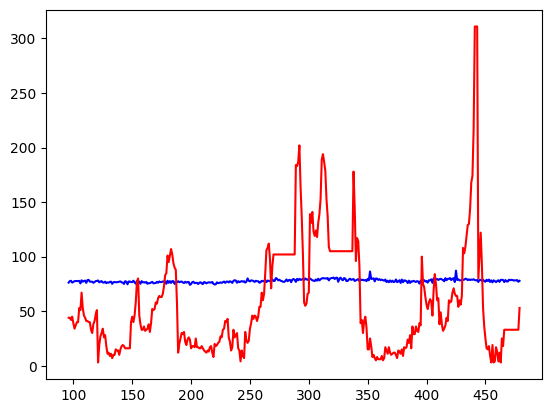

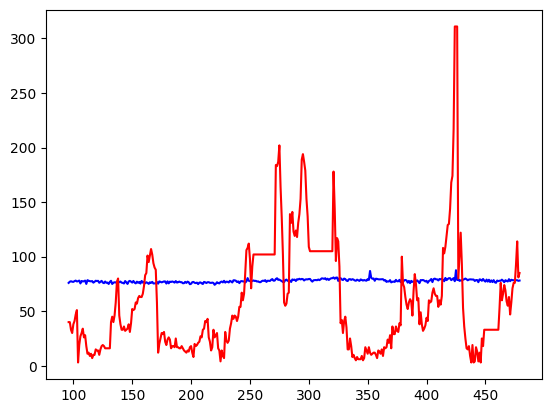

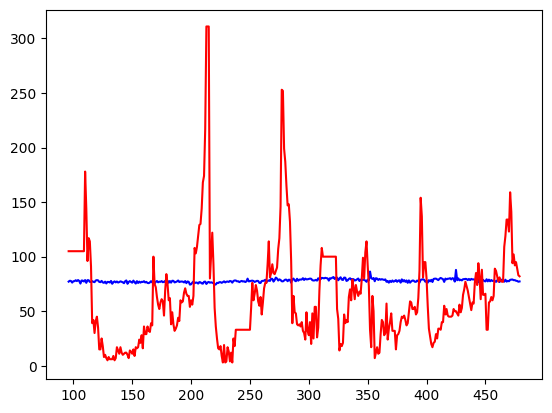

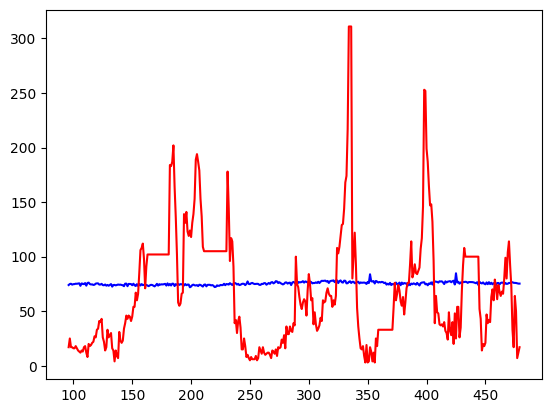

In [22]:

x1 = np.arange(histories[0].shape[2],histories[0].shape[2]+predicts[0].shape[1])
x2 = np.arange(histories[0].shape[2])
print(x1)
for i in range(10):
    y1 = predicts[0][i*10].cpu()
    y2 = ground_truth[0][i*10].cpu()
    y3 = histories[0][i,0,:].cpu()

    fig, ax = plt.subplots()
    ax.plot(x1, y1, label='predicts', color='blue')
    ax.plot(x1, y2, label='ground_truth', color='red')
    #ax.plot(x2,y3,label = 'histories',color='green')

    plt.show()